In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

sns.set_context("paper")
simHei = FontProperties(fname=r'/usr/share/fonts/Chinses/simhei.ttf', size=10) 

In [2]:
FDR_THRESHOLD = 0.05 #ASV差异FDR阈值
RANDOM_SEED = 0 #模型随机种子

In [3]:
asv_data = pd.read_csv('../data/Preprocess/rawdata_16S_abundance.tsv', index_col=0, sep='\t')
taxa_data = pd.read_csv('../data/Preprocess/rawdata_16S_taxa.tsv', index_col=0, sep='\t')
asv_data.head(2)

,N579,PP196_1,PP01_1,N621,N399,PP117_1,PP80_1,N556,PP144_1,PP190_1,...,N607,PP106_1,N569,PP37_1,N568,N630,N540,PP41_1,N401,PP119_1
#OTU ID,,,,,,,,,,,,,,,,,,,,,
44001a72292c6ac78f98d2ffaac23065,2.767849,3.595795,15.481491,17.990444,4.483103,9.982057,6.053326,2.459807,13.499211,2.756187,...,12.580336,6.756263,2.159016,22.850765,40.771558,3.832416,3.476722,7.667644,6.834232,3.646867
3016b070726d0a9e6cdb87c4a3914d07,1.514439,1.535658,1.322523,0.392401,1.487702,4.264077,0.701903,6.513934,2.441378,0.791569,...,0.571277,0.579189,0.437207,0.386204,0.546048,19.311710,0.361725,3.666054,0.772952,1.642549


1.385477171098479e-14

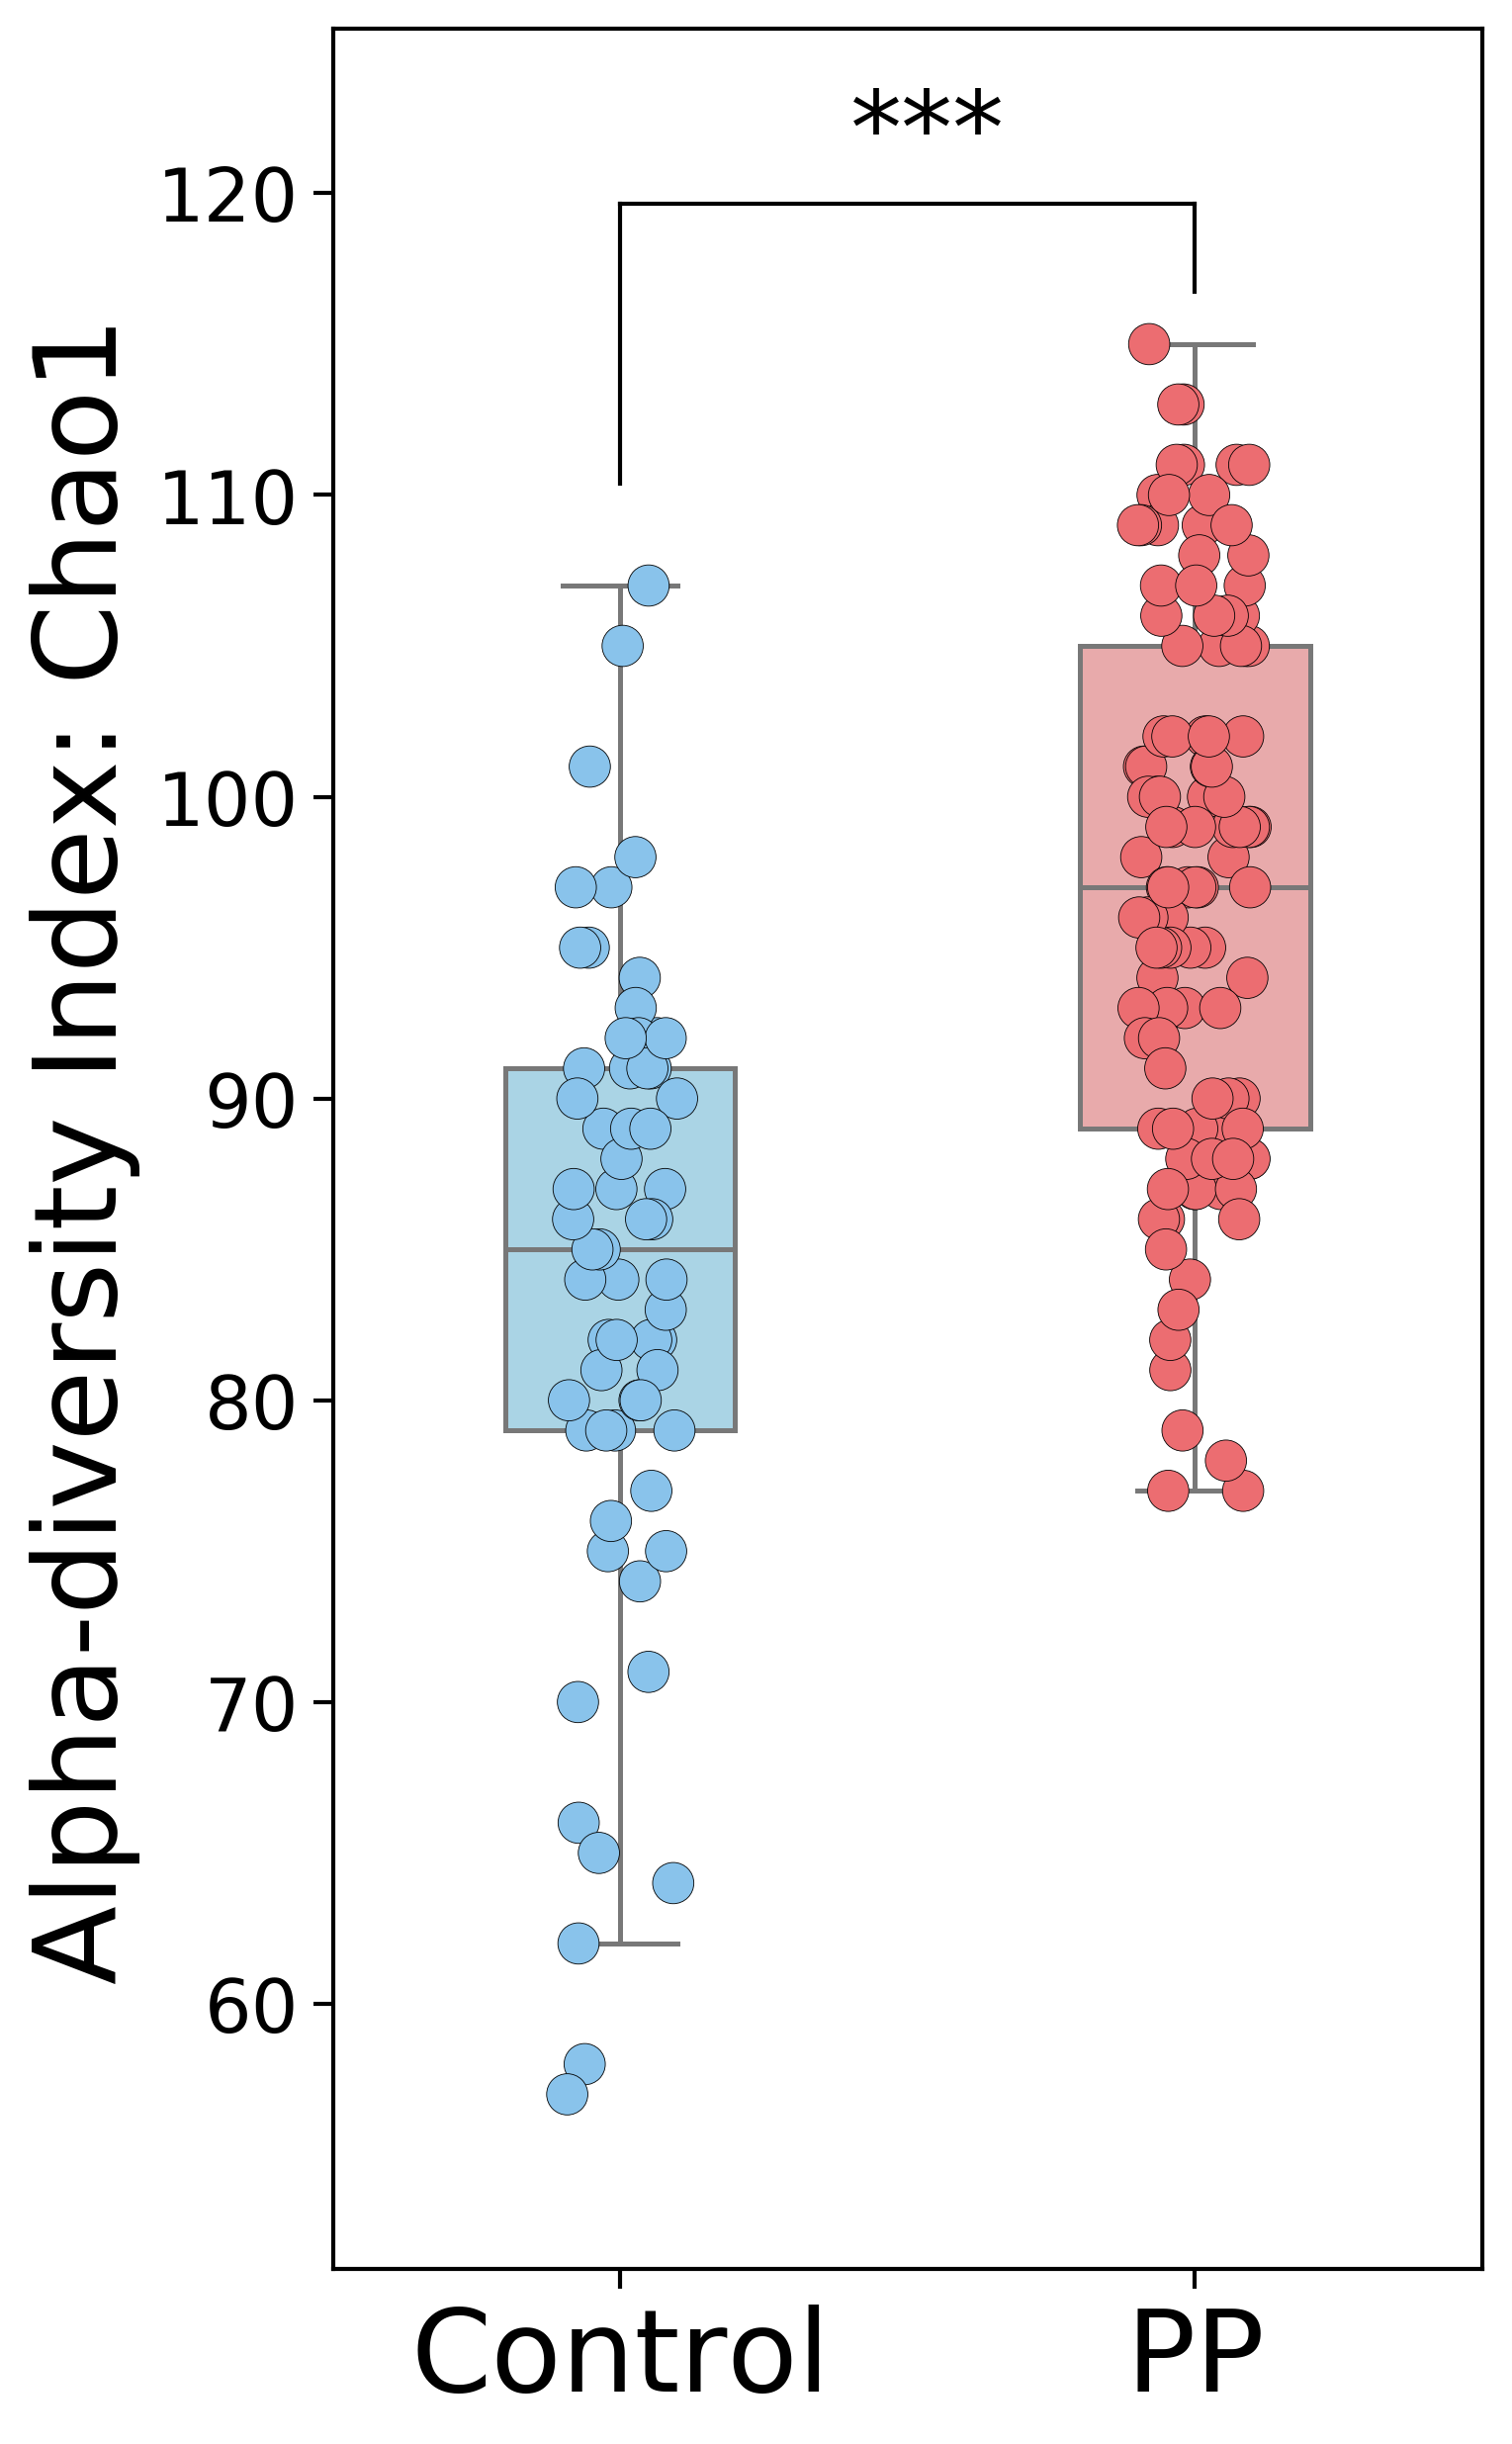

In [151]:
from skbio.diversity import alpha_diversity
from scipy.stats import ttest_ind
### Alpha #chao1, shannon, simpson
alpha_chao1 = alpha_diversity('chao1', asv_data.values.T, list(asv_data.columns))
alpha_chao1 = pd.DataFrame({'alpha':alpha_chao1.values}, index=asv_data.columns)
alpha_chao1['Group'] = ['PP' if 'PP' in i else 'Control' for i in asv_data.columns]
fig = plt.figure(figsize=(5, 10), dpi=300)
_ = sns.boxplot(x='Group', y='alpha', data=alpha_chao1, order=['Control', 'PP'], palette=['#a0d8ef', '#f2a0a1'],
                width=0.4, fliersize=0)
_ = sns.stripplot(x="Group", y="alpha", data=alpha_chao1, palette=['#89c3eb', '#ec6d71'], 
                  edgecolor='k', linewidth=0.2, size=10)
### 统计检验
t, p = ttest_ind(alpha_chao1.loc[alpha_chao1['Group']=='Control', 'alpha'], 
                 alpha_chao1.loc[alpha_chao1['Group']=='PP', 'alpha'])
p
dy = max(alpha_chao1['alpha'])-min(alpha_chao1['alpha'])
#_ = plt.annotate('p='+str(round(p, 3)), xy=(0.6, 0.93), xycoords='axes fraction')
_ = plt.plot([0, 1], [max(alpha_chao1['alpha'])+dy*0.08, max(alpha_chao1['alpha'])+dy*0.08], lw=1., c='k')
_ = plt.plot([0, 0], [max(alpha_chao1['alpha'])-dy*0.08, max(alpha_chao1['alpha'])+dy*0.08], lw=1., c='k')
_ = plt.plot([1, 1], [max(alpha_chao1['alpha'])+dy*0.03, max(alpha_chao1['alpha'])+dy*0.08], lw=1., c='k')
_ = plt.annotate('***', xy=(0.45, 0.94), xycoords='axes fraction', fontsize=25)
###
_ = plt.ylim([min(alpha_chao1['alpha'])-dy*0.1, max(alpha_chao1['alpha'])+dy*0.18])
_ = plt.ylabel('Alpha-diversity Index: Chao1',fontsize=28)
_ = plt.xticks(fontsize=28)
_ = plt.yticks(fontsize=18)
_ = plt.xlabel('')
_ = plt.show()

In [147]:
from scipy.spatial.distance import braycurtis, euclidean, correlation, cosine
from skbio import DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim, permanova

def plot_ellipses(axis, x, y, std=1, facecolor='None', edgecolor='k', alpha=0.5):
    from matplotlib.patches import Ellipse
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    e = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*std*2, height=lambda_[1]*std*2, angle=np.rad2deg(np.arccos(v[0, 0])))
    e.set_facecolor(facecolor)
    e.set_edgecolor(edgecolor)
    e.set_alpha(alpha)
    axis.add_artist(e)
    return axis

dis_method = braycurtis
level_microbiome = asv_data.T
distance_matrix = pd.DataFrame(np.zeros((level_microbiome.shape[0], level_microbiome.shape[0])), 
                               index=level_microbiome.index, columns=level_microbiome.index)
for i in distance_matrix:
    for j in distance_matrix:
        distance_matrix.loc[i, j] = dis_method(level_microbiome.loc[i, :], level_microbiome.loc[j, :])

ordination_result = pcoa(DistanceMatrix(distance_matrix.values, list(distance_matrix.index)))
pc1, pc2 = ordination_result.proportion_explained.loc['PC1'], ordination_result.proportion_explained.loc['PC2']

### 分组检验
dm = DistanceMatrix(distance_matrix.values, list(distance_matrix.index))
matched_grouping = [1 if 'PP' in i else 0 for i in distance_matrix.index]
print('### 分组检验')
anosim(dm, grouping=matched_grouping)
permanova(dm, grouping=matched_grouping)

/opt/conda/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.1440239096337336 and the largest is 4.966020049709561.
  RuntimeWarning


### 分组检验


method name                 ANOSIM
test statistic name              R
sample size                    168
number of groups                 2
test statistic            0.165098
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     168
number of groups                  2
test statistic              3.23888
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

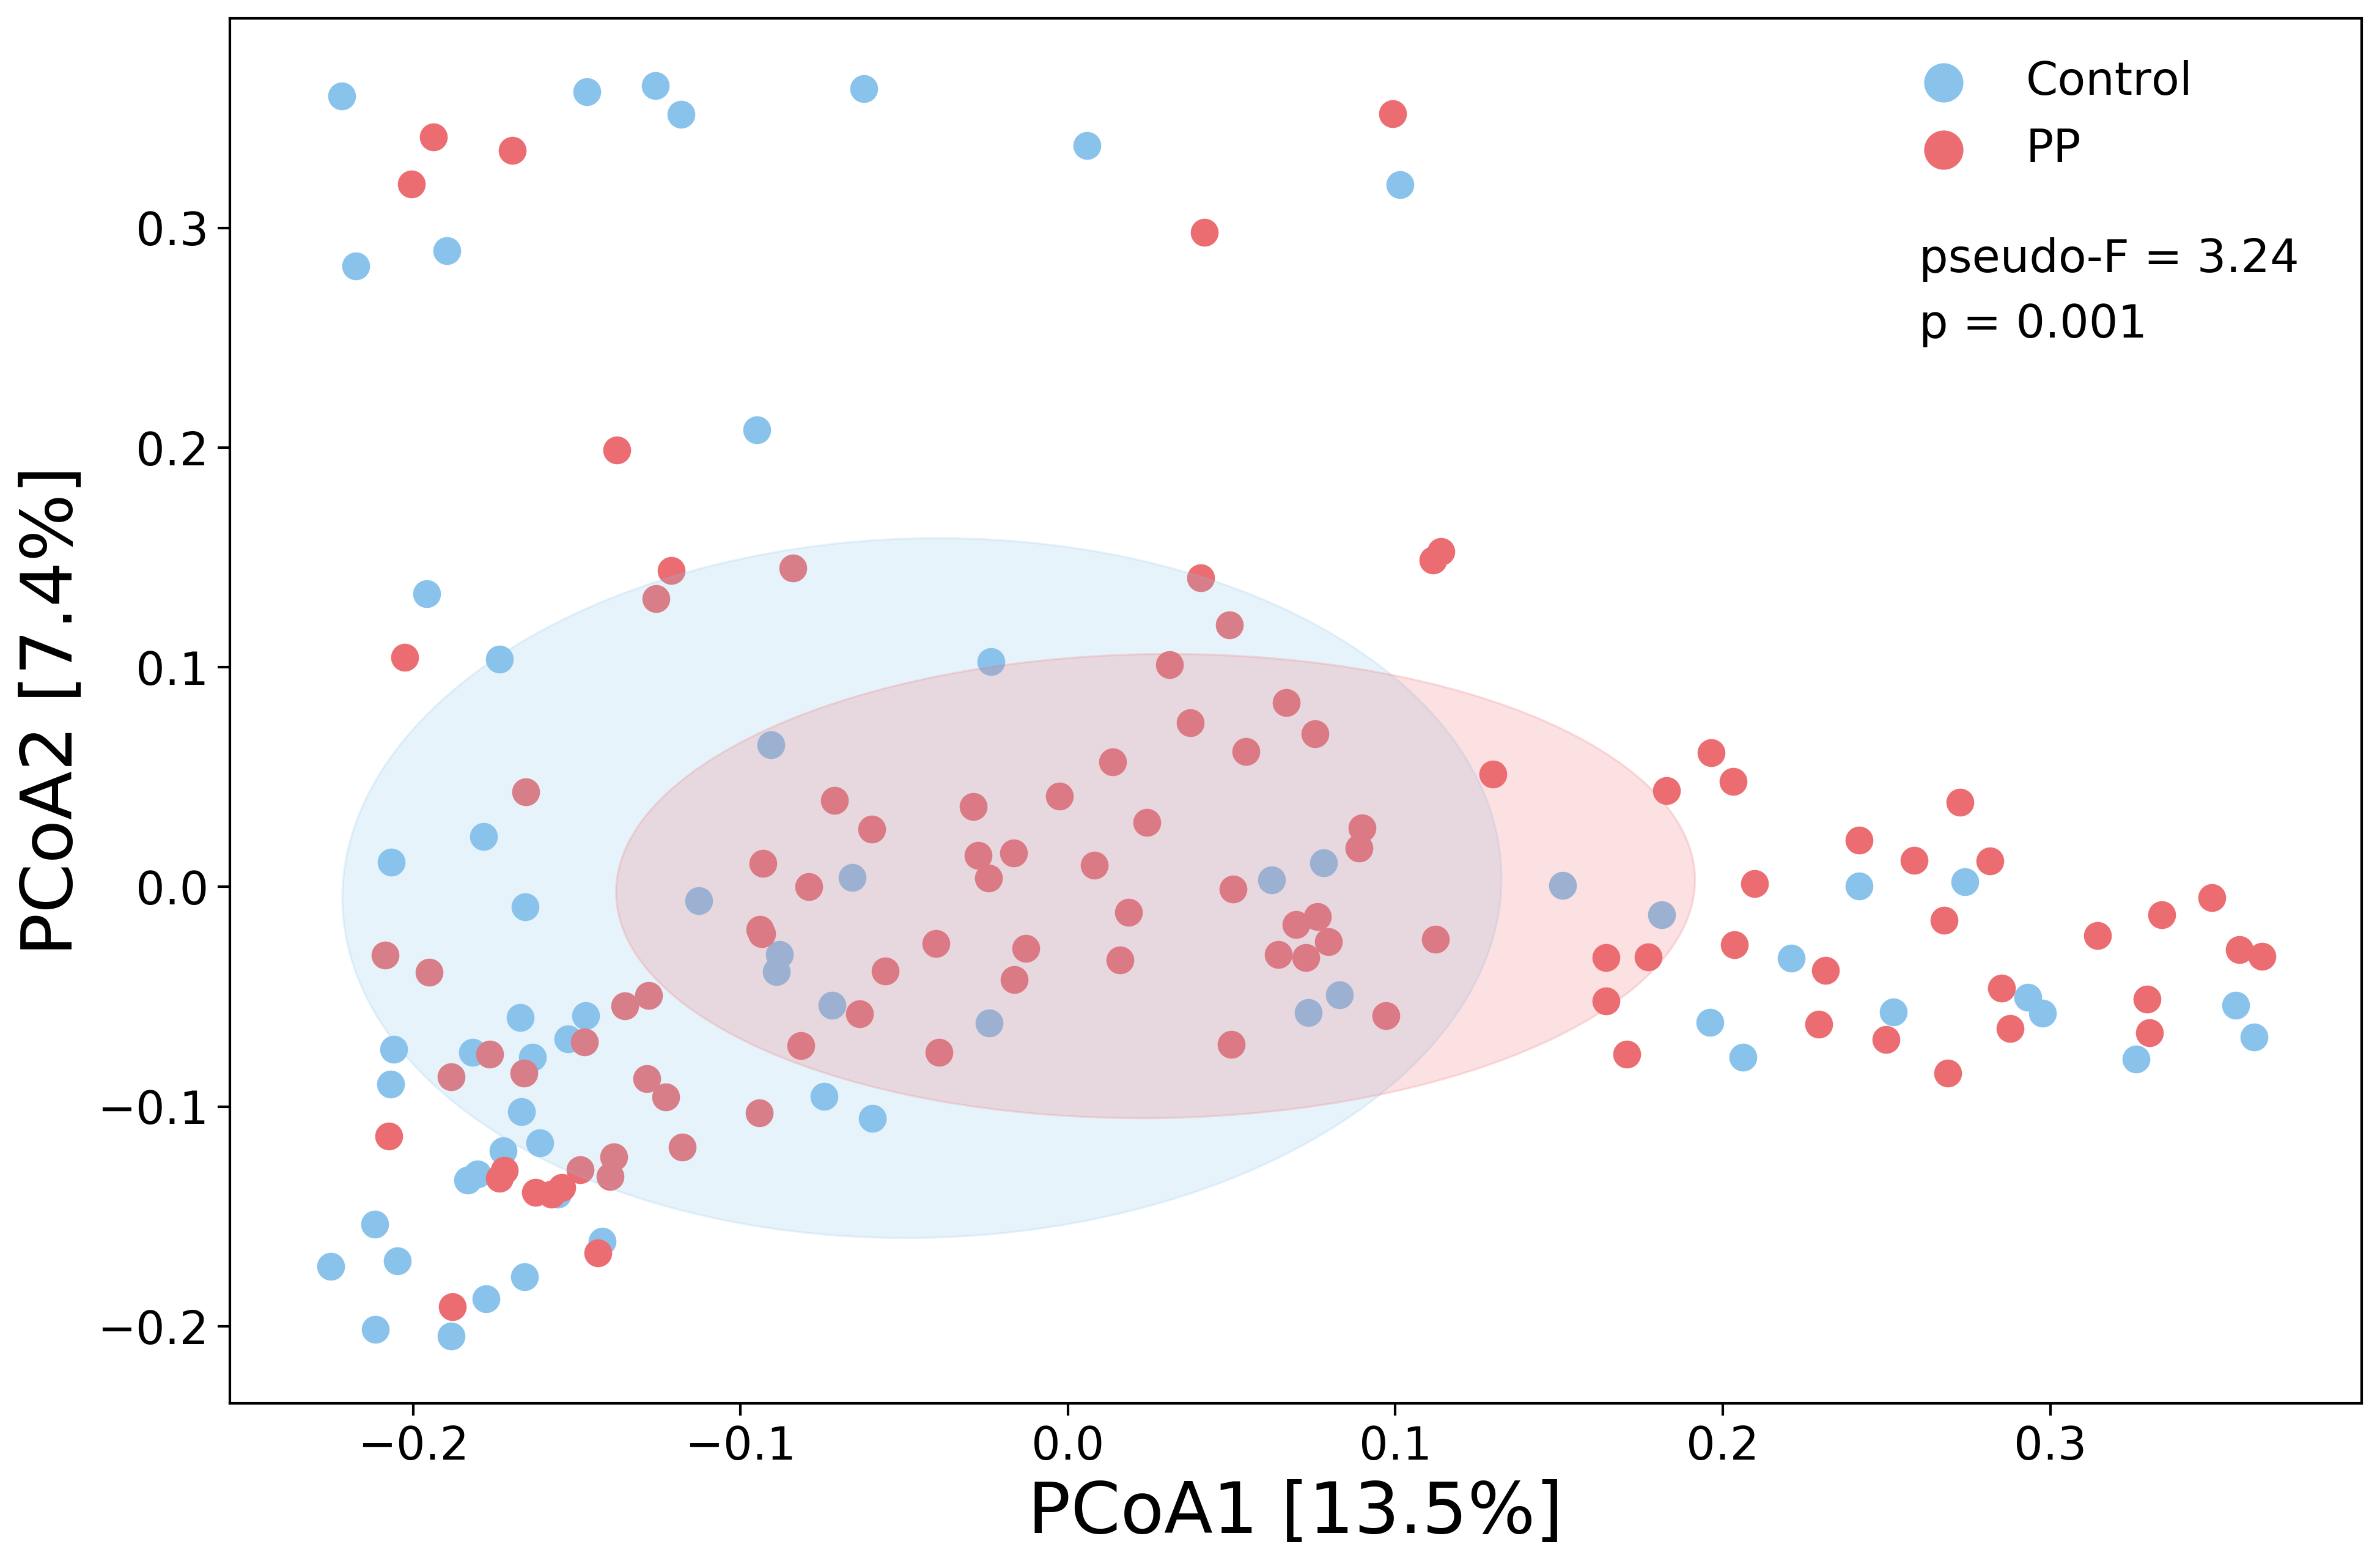

In [161]:
### plot
level_microbiome_tran = ordination_result.samples
_ = plt.figure(figsize=(15, 10), dpi=300)
ax = plt.subplot(111)

for group, color, marker in [('Control', '#89c3eb', 'o'), ('PP', '#ec6d71', 'o')]:
    samples_PP = [i for i in level_microbiome.index if 'PP' in i]
    samples_C = [i for i in level_microbiome.index if 'PP' not in i]
    samples = samples_C if group == 'Control' else samples_PP
    _ = plt.scatter(level_microbiome_tran.loc[samples, 'PC1'], level_microbiome_tran.loc[samples, 'PC2'], 
                    marker=marker, lw=2, color=color, label=group, s=80)
    _ = plot_ellipses(ax, level_microbiome_tran.loc[samples, 'PC1'], level_microbiome_tran.loc[samples, 'PC2'], 
                      std=1.0, facecolor=color, edgecolor=color, alpha=0.2)

_ = plt.annotate('pseudo-F = 3.24', (0.26, 0.28), fontsize=18)
_ = plt.annotate('p = 0.001', (0.26, 0.25), fontsize=18)
#_ = plt.annotate('PERMANOVA:', (-0.1, 0.38), fontsize=13)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
_ = plt.xlabel('PCoA1 ['+str(round(pc1*100, 1))+'%]', fontsize=28)
_ = plt.ylabel('PCoA2 ['+str(round(pc2*100, 1))+'%]', fontsize=28)
_ = plt.legend(bbox_to_anchor=[0.94, 1], fontsize=18, frameon=False, markerscale=1.5)
_ = plt.show()